# A Study of the Effect of YouTube Tech Channels to the Units Sold of Newly Released Devices

In [139]:
# Libraries used

import requests
from bs4 import BeautifulSoup
import pandas as pd
from fake_useragent import UserAgent
import time, os
import numpy as np
import sys
from tqdm import tqdm
from api import *
import google_auth_oauthlib.flow
import googleapiclient.discovery
import googleapiclient.errors
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression, LogisticRegression
from sklearn.model_selection import (cross_val_score, train_test_split, 
                                     KFold, GridSearchCV, train_test_split) 
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor

## Scrapping

### In this section, we will scrap Wikipedia to get the number of units sold for each device.

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_best-selling_mobile_phones#Top-selling_mobile_phones"
wikipage = requests.get(url)
soup = BeautifulSoup(wikipage.text, "html5lib")
print(wikipage.status_code)

200


In [3]:
columns = soup.find('table', class_='wikitable').find('tr') 

In [4]:
column_names = columns.text
column_names = column_names.replace('\n','  ').strip().split('  ')
column_names = [value for value in column_names if value != '']
column_names.append('x')

In [5]:
data = soup.find('table', class_='wikitable').find('tbody')

In [6]:
devices_list = []
for row in data.find_all('tr')[1:]:
    devices_list.append(row.text.strip().split('\n\n'))

In [7]:
units_sold_df = pd.DataFrame(devices_list, columns=column_names)
units_sold_df

,Manufacturer,Model,Form factor,Smartphone?,Year,Graph (million units),x
0,Nokia,1100,Bar,No,2003,250[3][1][4],250
1,Nokia,1110,Bar,No,2005,250[3][1][5],250
2,Apple,iPhone 6 and iPhone 6 Plus,Touchscreen,Yes,2014,222[2][3],222
3,Nokia,105 (2013) and 105 (2015),Bar,No,2013,200[6],200
4,Nokia,3210,Bar,No,1999,160[1][5][7],160
...,...,...,...,...,...,...,...
110,LG,G2,Touchscreen,Yes,2013,3[62][63],3
111,LeTV,LeEco Le 1s,Touchscreen,Yes,2016,3[64][65],3
112,Google,Pixel and Pixel XL,Touchscreen,Yes,2016,2.1[66],2.1
113,Palm,Centro,Keyboard bar,Yes,2007,2[67],2


In [8]:
units_sold_df.drop(columns=['Graph (million units)', 'Form factor'],inplace=True)
units_sold_df.head()

,Manufacturer,Model,Smartphone?,Year,x
0,Nokia,1100,No,2003,250
1,Nokia,1110,No,2005,250
2,Apple,iPhone 6 and iPhone 6 Plus,Yes,2014,222
3,Nokia,105 (2013) and 105 (2015),No,2013,200
4,Nokia,3210,No,1999,160


In [9]:
units_sold_df.rename(columns={'Manufacturer':'company_name', 
                              'Model':'device', 
                              'x':'units', 
                              'Smartphone?':'smartphone?', 
                              'Year': 'year'},inplace=True)

In [10]:
units_sold_df = units_sold_df[units_sold_df['smartphone?'] == 'Yes'].reset_index(drop=True).drop(columns=['smartphone?'])

In [11]:
units_sold_df['year'] = units_sold_df['year'].astype('int32')
units_sold_df['units'] = units_sold_df['units'].astype('float32') * 1000000

In [12]:
units_sold_df['company_name'] = units_sold_df.company_name.str.upper()
units_sold_df['device'] = units_sold_df.device.str.upper()

In [13]:
units_sold_df.head()

,company_name,device,year,units
0,APPLE,IPHONE 6 AND IPHONE 6 PLUS,2014,2.220000e+08
1,NOKIA,6600,2003,1.500000e+08
2,NOKIA,5230,2009,1.500000e+08
3,APPLE,IPHONE 11,2019,1.021000e+08
4,APPLE,IPHONE 12 AND IPHONE 12 MINI,2020,1.000000e+08


We notice that in some cases, there are two devices in the 'device' column. Next, we will clean it.

In [14]:
cn = []                 # company_name
d = []                  # device
y = []                  # year
u = []                  # year

for a_string in units_sold_df.device:
    for a_list in a_string.split('AND'):
        
        cn.append(units_sold_df[units_sold_df['device'] == a_string].company_name.values[0])
        d.append(a_list.split(',')[0].strip().upper())
        y.append(units_sold_df[units_sold_df['device'] == a_string].year.values[0])
        u.append(units_sold_df[units_sold_df['device'] == a_string].units.values[0].astype(int))

units_sold_df_mod = pd.DataFrame({'company_name': cn,
                                  'device': d,
                                  'year': y,
                                  'units': u})

In [15]:
units_sold_df_mod.head()

,company_name,device,year,units
0,APPLE,IPHONE 6,2014,222000000
1,APPLE,IPHONE 6 PLUS,2014,222000000
2,NOKIA,6600,2003,150000000
3,NOKIA,5230,2009,150000000
4,APPLE,IPHONE 11,2019,102099998


### In this section, we will scrap (https://www.gsmarena.com/makers.php3) to get all companies names, devices and number of devices.

In [26]:
the_link = 'https://www.gsmarena.com/makers.php3'
ua = UserAgent()
def get_soup(the_link):
    source_code = requests.get(the_link, headers = {'User-agent': ua.random})
    return BeautifulSoup(source_code.text, 'html5lib')

Error occurred during loading data. Trying to use cache server https://fake-useragent.herokuapp.com/browsers/0.1.11
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/fake_useragent/utils.py", line 154, in load
    for item in get_browsers(verify_ssl=verify_ssl):
  File "/usr/local/lib/python3.7/dist-packages/fake_useragent/utils.py", line 99, in get_browsers
    html = html.split('<table class="w3-table-all notranslate">')[1]
IndexError: list index out of range


In [27]:
soup = get_soup(the_link)
list_of_companies = soup.find('div', {'class': 'st-text'})

company_name = []
links = []
number_of_devices = []

for anchor in list_of_companies.findAll('a'):
    company_name.append(anchor.text.strip())
    links.append('https://www.gsmarena.com/'+anchor.attrs['href'])
    number_of_devices.append(anchor.find('span').text)

We notice that companies names and the number of devices in company_name list are compined into a single string as shown below.

In [28]:
print(company_name[:2])
print(number_of_devices[:2])

['Acer100 devices', 'alcatel405 devices']
['100 devices', '405 devices']


We will now clean the data

In [29]:
for i in range(len(company_name)):
    company_name[i] = company_name[i].replace(number_of_devices[i],'')

In [30]:
# Now data is cleaned
print(company_name[:2])
print(number_of_devices[:2])

['Acer', 'alcatel']
['100 devices', '405 devices']


In [31]:
df1 = pd.DataFrame()
df1['company_name'] = company_name
df1['link'] = links
df1['number_of_devices'] = [int(i.replace('devices','').strip()) for i in number_of_devices]

In [32]:
df1['company_name'] = df1.company_name.str.upper()

In [33]:
df2 = pd.merge(df1, units_sold_df_mod, on='company_name')[['company_name', 'link']].drop_duplicates().reset_index(drop=True)

In [34]:
df2

,company_name,link
0,APPLE,https://www.gsmarena.com/apple-phones-48.php
1,GOOGLE,https://www.gsmarena.com/google-phones-107.php
2,HTC,https://www.gsmarena.com/htc-phones-45.php
3,HUAWEI,https://www.gsmarena.com/huawei-phones-58.php
4,LG,https://www.gsmarena.com/lg-phones-20.php
5,MOTOROLA,https://www.gsmarena.com/motorola-phones-4.php
6,NOKIA,https://www.gsmarena.com/nokia-phones-1.php
7,OPPO,https://www.gsmarena.com/oppo-phones-82.php
8,PALM,https://www.gsmarena.com/palm-phones-27.php
9,SAMSUNG,https://www.gsmarena.com/samsung-phones-9.php


Now we wand to scrap on the companies that we have its devices number of units sold.

In [36]:
devices = []
companies_names = []
for a_link in tqdm(df2.link.values):   #for a_link in ['https://www.gsmarena.com/acer-phones-59.php']:
    soup = get_soup(a_link)
    cn = df1[df1['link'] == a_link]['company_name'].values[0]
    
    # We'll now generate a list with all the pages containing a company's device 
    all_pages_links = [a_link]
    list_of_pages = soup.find('div', {'class': 'nav-pages'})
    try:
        for i in list_of_pages.find_all('a'):
            all_pages_links.append('https://www.gsmarena.com/'+i.get('href'))
    except:
        pass
    
    # We'll get all the devices names 
    for page_link in all_pages_links:
        soup = get_soup(page_link)
        list_of_devices = soup.find('div', {'class': 'makers'})
        time.sleep(1+np.random.randint(0,1))
        try:
            for name in list_of_devices.find_all('span'):
                time.sleep(1+np.random.randint(0,1))
                devices.append(name.text)
                companies_names.append(cn)
        except:
            devices.append(list_of_pages.find('span').text)
    time.sleep(1+np.random.randint(0,1))

In [ ]:
# Now we will create a dataframe that contains the companies names and the names of the devices
CN_D = pd.DataFrame({'company_name':companies_names, 'device':devices})
CN_D.to_csv('CN_D.csv', index = False)

Since scrapping takes alot of time to run, we'll use the saved data in the csv file.

In [37]:
CN_D = pd.read_csv('CN_D.csv')
CN_D

,company_name,device
0,APPLE,iPhone 13 Pro Max
1,APPLE,iPhone 13 Pro
2,APPLE,iPhone 13
3,APPLE,iPhone 13 mini
4,APPLE,iPad mini (2021)
...,...,...
4207,XIAOMI,Mi Max 4 Pro
4208,XIAOMI,Mi Max 4
4209,XIAOMI,Mi 6c
4210,XIAOMI,Redmi Pro 2


In [38]:
# Now we will join the two dataframes
df_devices = pd.merge(df1, CN_D, on='company_name')

In [39]:
df_devices['device'] = df_devices.device.str.upper()

In [40]:
df_devices

,company_name,link,number_of_devices,device
0,APPLE,https://www.gsmarena.com/apple-phones-48.php,98,IPHONE 13 PRO MAX
1,APPLE,https://www.gsmarena.com/apple-phones-48.php,98,IPHONE 13 PRO
2,APPLE,https://www.gsmarena.com/apple-phones-48.php,98,IPHONE 13
3,APPLE,https://www.gsmarena.com/apple-phones-48.php,98,IPHONE 13 MINI
4,APPLE,https://www.gsmarena.com/apple-phones-48.php,98,IPAD MINI (2021)
...,...,...,...,...
4207,XIAOMI,https://www.gsmarena.com/xiaomi-phones-80.php,231,MI MAX 4 PRO
4208,XIAOMI,https://www.gsmarena.com/xiaomi-phones-80.php,231,MI MAX 4
4209,XIAOMI,https://www.gsmarena.com/xiaomi-phones-80.php,231,MI 6C
4210,XIAOMI,https://www.gsmarena.com/xiaomi-phones-80.php,231,REDMI PRO 2


### In the next section, we will scrap YouTube to get the length of the video, number of like and dislikes, the channels names, and the devices the reviews were about.

In [ ]:
videoIds=[]
scopes = ["https://www.googleapis.com/auth/youtube.readonly"]
os.environ["OAUTHLIB_INSECURE_TRANSPORT"] = "1"

In [ ]:
# SETUP
api_service_name = "youtube"
api_version = "v3"
token = api_token
youtube = googleapiclient.discovery.build(api_service_name, api_version, developerKey=token)

In [ ]:
# Three of the most popular Tech channels were selected
channels_names = ['marquesbrownlee','unboxtherapy','Mrwhosetheboss']
ranges = [] # Number of videos devided by 50

In [ ]:
def get_upload_list(a_channel_name):
    uploads_lists = []
    # Get Channel details (Find the uploads playlist id from it)
    channelReq = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        forUsername=a_channel_name
    )
    channelRes = channelReq.execute()
    uploads_lists.append(channelRes['items'][0]['contentDetails']['relatedPlaylists']['uploads'])
    
    
    return uploads_lists

In [ ]:
def get_vids_ids(channels_names, uploads_list, ranges):
    videos_Ids=[]
    channels_names_modified = []
    
    for i in range(len(channels_names)):
        # ---------------------------------------------------------------------------------
        # Get the uploads of a channel
        uploadsReq = youtube.playlistItems().list(
            part="snippet,contentDetails",
            maxResults=50,
            playlistId=uploads_list[i],
        )
        uploadsRes = uploadsReq.execute()
        for video in range(len(uploadsRes['items'])):
            videos_Ids.append(uploadsRes['items'][video]['contentDetails']['videoId'])
            channels_names_modified.append(channels_names[i])
        # ---------------------------------------------------------------------------------    
        NEXT_PAGE_TOKEN = uploadsRes['nextPageToken']
        for page in range(ranges[i]):
            # Get the uploads of a channel
            nextUploadsReq = youtube.playlistItems().list(
                part="snippet,contentDetails",
                maxResults=50,
                playlistId=uploads_list[i],
                pageToken=NEXT_PAGE_TOKEN
            )
            nextUploadsRes = nextUploadsReq.execute()
            try:
                NEXT_PAGE_TOKEN = nextUploadsRes['nextPageToken']
                for video in range(len(nextUploadsRes['items'])):
                    videos_Ids.append(nextUploadsRes['items'][video]['contentDetails']['videoId'])
                    channels_names_modified.append(channels_names[i])
            except:
                print('No next page on:   '+ channels_names[i])
    return videos_Ids, channels_names_modified

In [ ]:
def get_vid_details(videoIds, channels_names_modified):
    titles = []
    tags = []
    likeCount = []
    viewCount = []
    dislikeCount = []
    commentCount = []
    vidDuration = []
    # ---------------------------------------------------------------------------------
    # Get channel's stats videos details
    fifties = 0
    for iter in range(len(videoIds)):
        vidReq = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=videoIds[iter]
        )
        vidRes = vidReq.execute()
        try:
            viewCount.append(vidRes['items'][0]['statistics']['viewCount'])
        except:
            print('video with no viewCount') 
            viewCount.append(None)
        try:
            likeCount.append(vidRes['items'][0]['statistics']['likeCount'])
        except:
            print('video with no likeCount') 
            likeCount.append(None)
        try:
            dislikeCount.append(vidRes['items'][0]['statistics']['dislikeCount'])
        except:
            print('video with no dislikeCount') 
            dislikeCount.append(None)
        try:
            commentCount.append(vidRes['items'][0]['statistics']['commentCount'])
        except:
            print('video with no commentCount') 
            commentCount.append(None)
        try:
            vidDuration.append(vidRes['items'][0]['contentDetails']['duration'])
        except:
            print('video with no vidDuration') 
            vidDuration.append(None)    
        try:
            titles.append(vidRes['items'][0]['snippet']['title'])
        except:
            print('video with no titles') 
            titles.append(None)
        try:
            tags.append(vidRes['items'][0]['snippet']['tags'])
        except:
            print('video with no tags') 
            tags.append(None)
            
    df = pd.DataFrame({'channel_name': channels_names_modified, 
                         'titles': titles, 
                         'tags': tags, 
                         'likes_number': likeCount, 
                         'views count': viewCount,
                         'dislikes_number': dislikeCount, 
                         'commens_count': commentCount,
                         'duration': vidDuration
                         })
    return df

In [43]:
yt_df.to_csv('youtube_data.csv')

In [42]:
yt_df = pd.read_csv('youtube_data.csv', index_col=0).reset_index(drop=True)

In [44]:
# We will now clean the duration and convert it to seconds
# We considered all the possibilities shown below:

# H M S
# H M
# H   S
# H 
#   M S
#   M
#     S

# Where (H = hours), (M = Minutes) and (S = Seconds).

for i in range(yt_df.shape[0]):
    x = yt_df.video_duration.str.strip('PT').iloc[i]
    if 'H' in x and 'M' in x and 'S' in x:
        h = int(x.split('H')[0])
        m = int(x.split('H')[1].split('M')[0])
        s = int(x.split('H')[1].split('M')[1].strip('S'))
        yt_df['video_duration'].iloc[i] = (h * 60 * 60) + (m * 60) + s
        
    elif 'H' in x and 'M' in x and 'S' not in x:
        h = int(x.split('H')[0])
        m = int(x.split('H')[1].strip('M'))
        yt_df['video_duration'].iloc[i] = (h * 60 * 60) + (m * 60)
        
    elif 'H' in x and 'M' not in x and 'S' in x:
        h = int(x.split('H')[0])
        s = int(x.split('H')[1].strip('S'))
        yt_df['video_duration'].iloc[i] = (h * 60 * 60) + s
                
    elif 'H' in x and 'M' not in x and 'S' not in x:
        h = int(x.strip('H'))
        yt_df['video_duration'].iloc[i] = (h * 60 * 60)
        
    elif not 'H' in x and 'M' in x and 'S' in x:
        m = int(x.split('M')[0])
        s = int(x.split('M')[1].strip('S'))
        yt_df['video_duration'].iloc[i] = (m * 60) + s
        
    elif not 'H' in x and 'M' in x and 'S' not in x:
        m = int(x.strip('M'))
        yt_df['video_duration'].iloc[i] = (m * 60)
        
    elif not 'H' in x and 'M' not in x and 'S' in x:
        s = int(x.strip('S'))
        yt_df['video_duration'].iloc[i] = s
    

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [45]:
# Let's now clean the column that contains the tags
yt_df.head(1)

,channel_name,titles,tags,likes_number,views count,dislikes_number,commens_count,video_duration
0,MKBHD,Surface Laptop Studio Impressions: Windows 11 ...,"['surface laptop', 'surface studio', 'surface ...",80208.0,2184860.0,1472.0,5720.0,687


In [46]:
# We want to get all the data inside each column and split each element into a new row

yt_df['channel_name'] = yt_df.channel_name.str.upper()
yt_df.dropna(inplace = True)
yt_df.reset_index(drop=True, inplace = True)

In [47]:
channel_name = []
titles = []
tags = []
likes_number = []
views_count = []
dislikes_number = []
commens_count = []
video_duration = []
for ii in range(yt_df.shape[0]): 
    for i in yt_df.tags.iloc[ii].strip("'[]'").split(','):
        channel_name.append(yt_df.channel_name.iloc[ii])
        tags.append(i.strip().strip("''").strip())
        titles.append(yt_df.titles.iloc[ii])
        likes_number.append(yt_df.likes_number.iloc[ii])
        dislikes_number.append(yt_df.dislikes_number.iloc[ii])
        commens_count.append(yt_df.commens_count.iloc[ii])
        video_duration.append(yt_df.video_duration.iloc[ii])
        views_count.append(yt_df['views count'].iloc[ii])

In [48]:
yt_df_modified = pd.DataFrame({'channel_name': channel_name,
                               'titles': titles,
                               'tags': tags,
                               'likes_number': likes_number,
                               'views_count': views_count,
                               'dislikes_number': dislikes_number,
                               'commens_count': commens_count,
                               'video_duration': video_duration})

In [49]:
yt_df_modified['tags'] = yt_df_modified.tags.str.upper()

In [50]:
yt_df_modified

,channel_name,titles,tags,likes_number,views_count,dislikes_number,commens_count,video_duration
0,MKBHD,Surface Laptop Studio Impressions: Windows 11 ...,SURFACE LAPTOP,80208.0,2184860.0,1472.0,5720.0,687
1,MKBHD,Surface Laptop Studio Impressions: Windows 11 ...,SURFACE STUDIO,80208.0,2184860.0,1472.0,5720.0,687
2,MKBHD,Surface Laptop Studio Impressions: Windows 11 ...,SURFACE LAPTOP STUDIO,80208.0,2184860.0,1472.0,5720.0,687
3,MKBHD,Surface Laptop Studio Impressions: Windows 11 ...,MKBHD,80208.0,2184860.0,1472.0,5720.0,687
4,MKBHD,Surface Laptop Studio Impressions: Windows 11 ...,MKBHD,80208.0,2184860.0,1472.0,5720.0,687
...,...,...,...,...,...,...,...,...
127117,UNBOX_THERAPY,Lacie 2big Quadra Unboxing & Overview in HD!,HOT,170.0,10440.0,5.0,17.0,283
127118,UNBOX_THERAPY,Lacie 2big Quadra Unboxing & Overview in HD!,SWAP,170.0,10440.0,5.0,17.0,283
127119,UNBOX_THERAPY,Lacie 2big Quadra Unboxing & Overview in HD!,7200RPM,170.0,10440.0,5.0,17.0,283
127120,UNBOX_THERAPY,Lacie 2big Quadra Unboxing & Overview in HD!,32MB,170.0,10440.0,5.0,17.0,283


### Final DataFrame preparation.

To obtain our final data frame, we will join the three datasets obtained from scrapping together.

In [51]:
df_devices.head(1)

,company_name,link,number_of_devices,device
0,APPLE,https://www.gsmarena.com/apple-phones-48.php,98,IPHONE 13 PRO MAX


In [52]:
yt_df_modified.head(1)

,channel_name,titles,tags,likes_number,views_count,dislikes_number,commens_count,video_duration
0,MKBHD,Surface Laptop Studio Impressions: Windows 11 ...,SURFACE LAPTOP,80208.0,2184860.0,1472.0,5720.0,687


In [53]:
units_sold_df_mod.head(1)

,company_name,device,year,units
0,APPLE,IPHONE 6,2014,222000000


In [54]:
pre_final_df = pd.merge(df_devices, 
                        units_sold_df_mod, 
                        on='device').drop(['number_of_devices', 'link', 'company_name_y'], axis=1)

In [55]:
yt_df_modified.head(1)

,channel_name,titles,tags,likes_number,views_count,dislikes_number,commens_count,video_duration
0,MKBHD,Surface Laptop Studio Impressions: Windows 11 ...,SURFACE LAPTOP,80208.0,2184860.0,1472.0,5720.0,687


In [56]:
df = pd.merge(pre_final_df, 
              yt_df_modified, 
              left_on = 'device', 
              right_on = 'tags').drop(['tags', 'titles'], axis=1)

In [57]:
df.head()

,company_name_x,device,year,units,channel_name,likes_number,views_count,dislikes_number,commens_count,video_duration
0,APPLE,IPHONE 12 PRO MAX,2020,29000000,MKBHD,289750.0,6380863.0,6569.0,19865.0,1505
1,APPLE,IPHONE 12 PRO MAX,2020,29000000,MKBHD,170900.0,5512865.0,3293.0,12763.0,609
2,APPLE,IPHONE 12 PRO MAX,2020,29000000,MKBHD,230897.0,6736834.0,6498.0,27074.0,1105
3,APPLE,IPHONE 12 PRO MAX,2020,29000000,MRWHOSETHEBOSS,226495.0,3954624.0,6898.0,23637.0,968
4,APPLE,IPHONE 12 PRO MAX,2020,29000000,MRWHOSETHEBOSS,155226.0,4382765.0,2691.0,13550.0,593


In [58]:
df.drop_duplicates(inplace = True, ignore_index = True)

In [59]:
df.head()

,company_name_x,device,year,units,channel_name,likes_number,views_count,dislikes_number,commens_count,video_duration
0,APPLE,IPHONE 12 PRO MAX,2020,29000000,MKBHD,289750.0,6380863.0,6569.0,19865.0,1505
1,APPLE,IPHONE 12 PRO MAX,2020,29000000,MKBHD,170900.0,5512865.0,3293.0,12763.0,609
2,APPLE,IPHONE 12 PRO MAX,2020,29000000,MKBHD,230897.0,6736834.0,6498.0,27074.0,1105
3,APPLE,IPHONE 12 PRO MAX,2020,29000000,MRWHOSETHEBOSS,226495.0,3954624.0,6898.0,23637.0,968
4,APPLE,IPHONE 12 PRO MAX,2020,29000000,MRWHOSETHEBOSS,155226.0,4382765.0,2691.0,13550.0,593


In [60]:
df.to_csv('final_df.csv')

## EDA

In [61]:
df = pd.read_csv('final_df.csv', index_col=0)
df.drop(df[df['device'] == 'IPHONE'].index, inplace=True)
df.drop('year', axis=1, inplace=True)
df.head()

,company_name_x,device,units,channel_name,likes_number,views_count,dislikes_number,commens_count,video_duration
0,APPLE,IPHONE 12 PRO MAX,29000000,MKBHD,289750.0,6380863.0,6569.0,19865.0,1505
1,APPLE,IPHONE 12 PRO MAX,29000000,MKBHD,170900.0,5512865.0,3293.0,12763.0,609
2,APPLE,IPHONE 12 PRO MAX,29000000,MKBHD,230897.0,6736834.0,6498.0,27074.0,1105
3,APPLE,IPHONE 12 PRO MAX,29000000,MRWHOSETHEBOSS,226495.0,3954624.0,6898.0,23637.0,968
4,APPLE,IPHONE 12 PRO MAX,29000000,MRWHOSETHEBOSS,155226.0,4382765.0,2691.0,13550.0,593


In [62]:
df.channel_name.unique()

array(['MKBHD', 'MRWHOSETHEBOSS', 'UNBOX_THERAPY'], dtype=object)

Let's see how many views each channel is likely to get more likes on its videos.

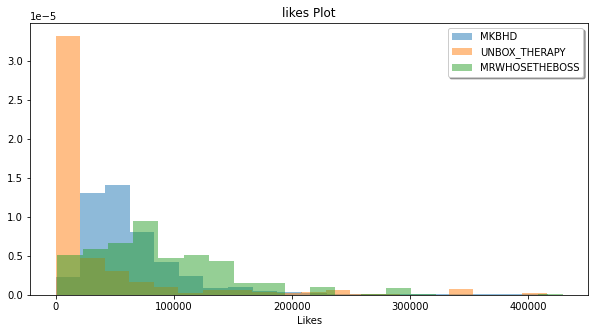

In [63]:
plt.figure(figsize=(10,5))
plt.hist(df[df['channel_name'] == 'UNBOX_THERAPY'].likes_number, bins = 20, density=True, alpha = 0.5)
plt.hist(df[df['channel_name'] == 'MRWHOSETHEBOSS'].likes_number, bins = 20, density=True, alpha = 0.5)
plt.hist(df[df['channel_name'] == 'MKBHD'].likes_number, bins = 20, density=True, alpha = 0.5)
plt.legend(['MKBHD','UNBOX_THERAPY', 'MRWHOSETHEBOSS'],shadow = True, loc = 0);
plt.xlabel('Likes')
plt.title('likes Plot')
plt.show();

Let's see what channel has the most views on its videos.

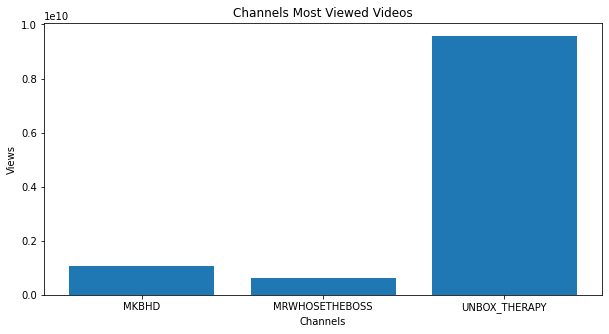

In [64]:
plt.figure(figsize=(10,5))
plt.bar(df.channel_name.unique(),df.groupby('channel_name').views_count.sum())
plt.title('Channels Most Viewed Videos')
plt.xlabel('Channels')
plt.ylabel('Views')
plt.show();

Let's now see what device has the most views on these channels.

In [65]:
views_units_df = pd.DataFrame([df.groupby(['device']).views_count.max(),df.groupby(['device']).units.max()]).T

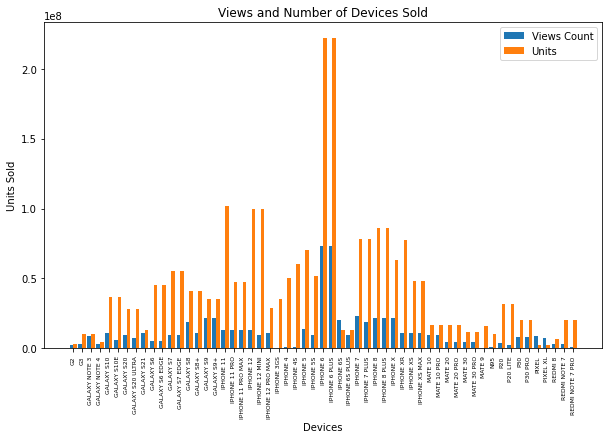

In [66]:
X_axis = np.arange(len(views_units_df.index))
plt.figure(figsize=[10,6])
plt.bar(X_axis - 0.2, views_units_df.views_count, 0.4, label = 'Views Count')
plt.bar(X_axis + 0.2, views_units_df.units, 0.4, label = 'Units')
plt.xticks(X_axis, views_units_df.index, rotation=90, fontsize=6)
plt.xlabel('Devices')
plt.ylabel('Units Sold')
plt.title("Views and Number of Devices Sold")
plt.legend()
plt.show()

In [ ]:
# Let's now see the relation between columns

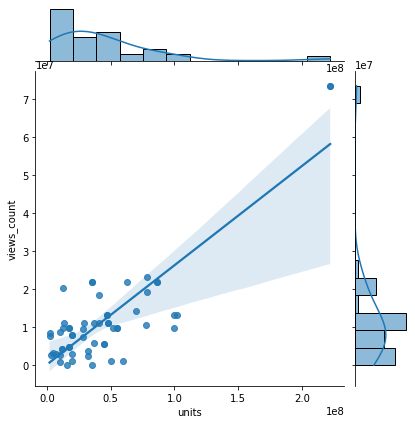

In [67]:
sns.jointplot(x="units", y="views_count", kind="reg", data=views_units_df);

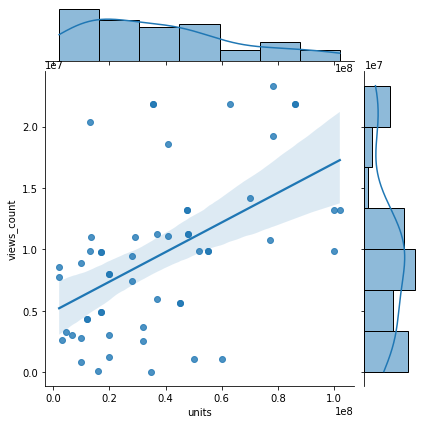

In [68]:
sns.jointplot(x="units", y="views_count", kind="reg", data=views_units_df.drop(['IPHONE 6', 'IPHONE 6 PLUS']));

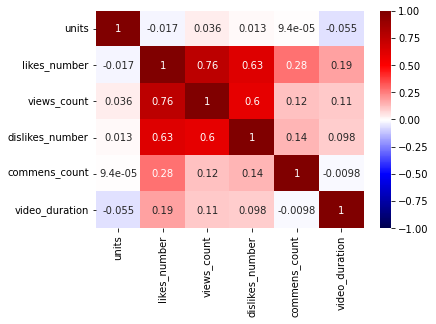

In [69]:
sns.heatmap(df.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

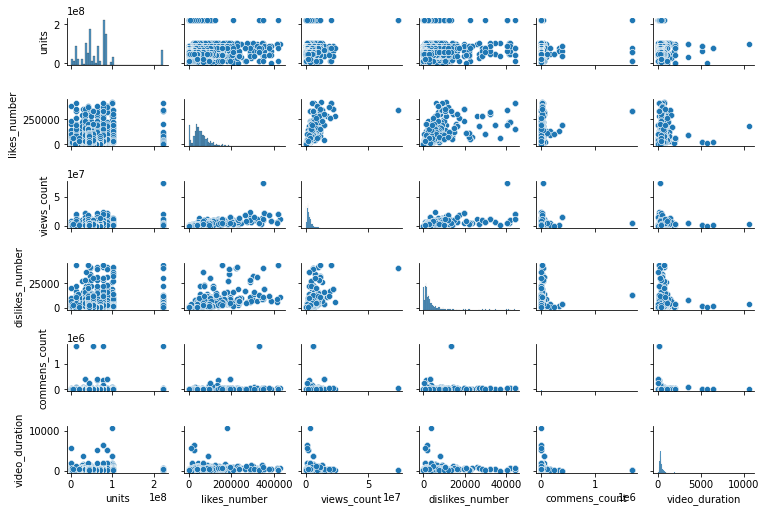

In [70]:
# Plot all of the variable-to-variable relations as scatterplots of original data
sns.pairplot(df, height=1.2, aspect=1.5);

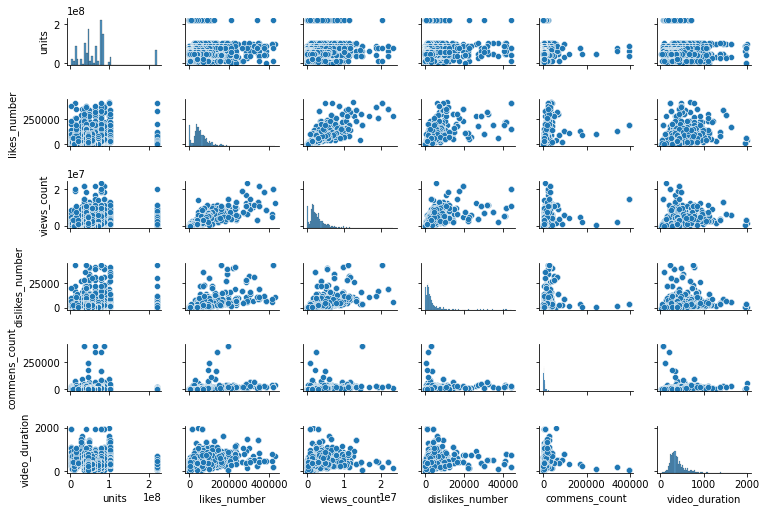

In [ ]:
# Plot all of the variable-to-variable relations as scatterplots of filtered data
sns.pairplot(df[(df.commens_count<1e6)&(df.views_count<5e7)&(df.video_duration<2100)], height=1.2, aspect=1.5);

In [75]:
# Lets clean our dataframe
df = df[(df.commens_count<1e6)&(df.views_count<5e7)&(df.video_duration<2100)].reset_index(drop=True).copy()

In [77]:
df.head(1)

,company_name_x,device,units,channel_name,likes_number,views_count,dislikes_number,commens_count,video_duration
0,APPLE,IPHONE 12 PRO MAX,29000000,MKBHD,289750.0,6380863.0,6569.0,19865.0,1505


## Linear Regression Experiments

Now we'll convert categorical data to binary codes. After that, we will assign a new variable X containing features and y that contains the target (units sold). Finally, we'll split the data into train_val (training and validation) and testing datasets.

In [78]:
df_ = pd.get_dummies(df, drop_first=True)

In [79]:
X = df_.drop(columns='units')
y = df_['units']

In [80]:
X_sc = StandardScaler().fit_transform(X)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2)

### LinearRegression()

In [81]:
kf = KFold(10, shuffle = True)

mae = []
mse = []
r2 = []
adj_r2 = []

for train_ind, val_ind in kf.split(X_train_val):
    X_train, X_val = X.iloc[train_ind], X.iloc[val_ind]
    y_train, y_val = y.iloc[train_ind], y.iloc[val_ind]

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    
    mae_ = mean_absolute_error(y_pred, y_val)
    mse_ = mean_squared_error(y_pred, y_val)
    r2_ = model.score(X_val, y_val)
    adj_r2_ = 1 - (1-r2_)*(len(y_val)-1)/(len(y_val)-X_val.shape[1]-1)
    
    mae.append(mae_)
    mse.append(mse_)
    r2.append(r2_)
    adj_r2.append(adj_r2_)
    
LR_model_scores = {'Mean Squared Error': np.mean(mse),
                   'Mean Absolute Error': np.mean(mae),
                   'r2': np.mean(r2),
                   'adj r2': np.mean(adj_r2)}

print(LR_model_scores)

{'Mean Squared Error': 1408566716922.7725, 'Mean Absolute Error': 34267.50662369481, 'r2': 0.999493895574348, 'adj r2': 0.9993433047427617}


### Lasso()

In [82]:
kf = KFold(10, shuffle = True)
params = {'alpha': np.linspace(0.0001,10,100)}
Lasso_model = GridSearchCV(Lasso(), param_grid=params, cv = kf, verbose=1)
Lasso_model.fit(X_train_val, y_train_val)
model_best = Lasso_model.best_estimator_
model_best.fit(X_train_val, y_train_val)

print(model_best)
print(model_best.coef_)
Lasso_model_scores = {'Mean Squared Error': mean_squared_error(model_best.predict(X_test), y_test),
                      'Mean Absolute Error': mean_absolute_error(model_best.predict(X_test), y_test),
                      'r2': model_best.score(X_train_val, y_train_val),
                      'adj r2': 1 - (1-model_best.score(X_train_val, y_train_val))*(len(y_train_val)-1)/(len(y_train_val)-X_train_val.shape[1]-1)}

print(Lasso_model_scores)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Lasso(alpha=0.5051454545454546, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
[ 6.31222178e-03 -6.33283841e-05 -1.04074904e-02  6.64686525e-04
  4.34875089e-01 -6.50034560e+07 -4.88238977e+07 -6.93061804e+07
 -4.88238773e+07  0.00000000e+00 -3.34168055e+07 -6.04588861e+07
  6.78996996e+06 -2.90988909e+07 -3.45990039e+07 -2.09989571e+06
 -2.09964272e+06 -1.11000932e+07 -1.10999908e+07 -2.55998530e+07
  5.90030476e+06  5.90013426e+06  1.59001904e+07  1.59001317e+07
  1.90004107e+06  1.89989104e+06 -3.69994344e+06 -3.70004089e+06
  2.95831515e+07 -2.50168357e+07 -2.50168803e+07  2.74830829e+07
  2.74824265e+07 -4.35170042e+07 -3.75151001e+07 -2.25164346e+07
 -1.25164323e+07 -2.51639151e+06 -2.05163242e+07  1.49483517e+08
  1.49483382e+08 -5.95166165e+07 -5.95165555e+07  5.78347638e+06
  5.78338601e+06  1.37834328e+07  1.37833423e+07 -9.51653641e+06
  4.8833

[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   47.9s finished


### Ridge()

In [83]:
kf = KFold(10, shuffle = True)
params = {'alpha': np.linspace(0.0001,10,100)}
Ridge_model = GridSearchCV(Ridge(), param_grid=params, cv = kf, verbose=1)
Ridge_model.fit(X_train_val, y_train_val)
model_best = Ridge_model.best_estimator_
model_best.fit(X_train_val, y_train_val)

print(model_best)
print(model_best.coef_)
Ridge_model_scores = {'Mean Squared Error': mean_squared_error(model_best.predict(X_test), y_test),
                      'Mean Absolute Error': mean_absolute_error(model_best.predict(X_test), y_test),
                      'r2': model_best.score(X_train_val, y_train_val),
                      'adj r2': 1 - (1-model_best.score(X_train_val, y_train_val))*(len(y_train_val)-1)/(len(y_train_val)-X_train_val.shape[1]-1)}

print(Ridge_model_scores)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.93667e-21): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.83678e-21): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.04392e-21): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.9312e-21): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.95657e-21): result may not be accurate.
  overwrite_a=True).T


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.78548e-21): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.93729e-21): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.00501e-21): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.89243e-21): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.92261e-21): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAl

Ridge(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
[-4.57972382e-05  2.55413494e-06 -6.38633668e-05 -1.45256085e-05
 -3.74499886e-02 -4.16487998e+07 -3.74777371e+07 -6.15698772e+07
 -3.74772659e+07  0.00000000e+00 -2.86124397e+07 -3.67290693e+07
  6.99654434e+06 -2.59606370e+07 -3.14603533e+07  1.03910672e+06
  1.03909616e+06 -7.96085280e+06 -7.96084093e+06 -2.24604790e+07
  9.03904532e+06  9.03900636e+06  1.90390749e+07  1.90390449e+07
  5.03910188e+06  5.03903723e+06 -5.60892001e+05 -5.60898478e+05
  3.75266290e+07 -1.70733037e+07 -1.70732964e+07  3.54265887e+07
  3.54259916e+07 -3.55731240e+07 -2.95703792e+07 -1.45732862e+07
 -4.57332164e+06  5.42665268e+06 -1.25732802e+07  1.57426569e+08
  1.57426029e+08 -5.15733058e+07 -5.15732739e+07  1.37266650e+07
  1.37266547e+07  2.17266615e+07  2.17266459e+07 -1.57333223e+06
  1.28266523e+07 -1.65733234e+07 -1.65733225e+07 -1.00953639e+07
 -1.00954264e+07 -1

[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   17.9s finished
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.42999e-21): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.42999e-21): result may not be accurate.
  overwrite_a=True).T


### ElasticNet

In [84]:
kf = KFold(10, shuffle = True)
params = {'alpha': np.linspace(0.0001,10,100)}
ElasticNet_model = GridSearchCV(ElasticNet(), param_grid=params, cv = kf, verbose=1)
ElasticNet_model.fit(X_train_val, y_train_val)
model_best = ElasticNet_model.best_estimator_
model_best.fit(X_train_val, y_train_val)

print(model_best)
print(model_best.coef_)
ElasticNet_model_scores = {'Mean Squared Error': mean_squared_error(model_best.predict(X_test), y_test),
                           'Mean Absolute Error': mean_absolute_error(model_best.predict(X_test), y_test),
                           'r2': model_best.score(X_train_val, y_train_val),
                           'adj r2': 1 - (1-model_best.score(X_train_val, y_train_val))*(len(y_train_val)-1)/(len(y_train_val)-X_train_val.shape[1]-1)}

print(ElasticNet_model_scores)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5429671034612360.0, tolerance: 599564992947007.6
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5471838905069917.0, tolerance: 615706745499849.8
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5415782836657509.0, tolerance: 619874357748225.6
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 545561366

ElasticNet(alpha=0.0001, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
[-8.89725901e-02  4.12203946e-03 -8.32708313e-02 -3.02121538e-02
 -5.92226961e+01 -4.19805080e+07 -3.78889709e+07 -5.74826172e+07
 -3.71787956e+07  0.00000000e+00 -2.89607170e+07 -3.57451306e+07
  2.39703071e+06 -2.57600003e+07 -3.08377948e+07  8.53136641e+05
  8.39575124e+05 -8.08374398e+06 -8.06569948e+06 -2.20224799e+07
  8.76098343e+06  8.70400243e+06  1.88040183e+07  1.87588412e+07
  4.84567318e+06  4.75264894e+06 -7.46300063e+05 -7.55896754e+05
  3.69384494e+07 -1.75614865e+07 -1.75497492e+07  3.47764950e+07
  3.39063103e+07 -3.57841886e+07 -2.61126393e+07 -1.50343219e+07
 -5.08834367e+06  4.87131469e+06 -1.30248083e+07  1.56742021e+08
  1.55923736e+08 -5.20656992e+07 -5.20166172e+07  1.31846650e+07
  1.31695390e+07  2.11798489e+07  2.11565910e+07 -2.1058

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6077229279450078.0, tolerance: 680644901056331.4
  positive)


In [85]:
print(Ridge_model_scores)
print(Lasso_model_scores)
print(ElasticNet_model_scores)
print(LR_model_scores)

{'Mean Squared Error': 4049330426268.227, 'Mean Absolute Error': 85919.44909817181, 'r2': 0.9999999999908183, 'adj r2': 0.9999999999906036}
{'Mean Squared Error': 5176837826738.885, 'Mean Absolute Error': 92084.92990789813, 'r2': 0.9999999870445351, 'adj r2': 0.9999999867415339}
{'Mean Squared Error': 4141974574857.1406, 'Mean Absolute Error': 148432.40660847878, 'r2': 0.9999815032352137, 'adj r2': 0.999981070634634}
{'Mean Squared Error': 1408566716922.7725, 'Mean Absolute Error': 34267.50662369481, 'r2': 0.999493895574348, 'adj r2': 0.9993433047427617}


### We notice that there is data leakage. We will now consider the dataframe by removing devices/companies/channels_names (dropping categorical features).

In [86]:
df_re_indixed = df.set_index(['channel_name','company_name_x', 'device'])

In [87]:
df_re_indixed = pd.get_dummies(df_re_indixed, drop_first=True)

In [88]:
X = df_re_indixed.drop(columns=['units'])
y = df_re_indixed['units']
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2)

In [89]:
X_train_val.head()

likes_number  ...  video_duration
channel_name  company_name_x device                        ...                
UNBOX_THERAPY APPLE          IPHONE 7             45745.0  ...             263
                             IPHONE 7 PLUS        51716.0  ...             226
                             IPHONE XS MAX        61544.0  ...             350
MKBHD         SAMSUNG        GALAXY S7 EDGE       35345.0  ...             237
UNBOX_THERAPY SAMSUNG        GALAXY S9            81616.0  ...             292

[5 rows x 5 columns]

In [90]:
# LinearRegression()
kf = KFold(10, shuffle = True)

mae = []
mse = []
r2 = []
adj_r2 = []

for train_ind, val_ind in kf.split(X_train_val):
    X_train, X_val = X.iloc[train_ind], X.iloc[val_ind]
    y_train, y_val = y.iloc[train_ind], y.iloc[val_ind]

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    
    mae_ = mean_absolute_error(y_pred, y_val)
    mse_ = mean_squared_error(y_pred, y_val)
    r2_ = model.score(X_val, y_val)
    adj_r2_ = 1 - (1-r2_)*(len(y_val)-1)/(len(y_val)-X_val.shape[1]-1)
    
    mae.append(mae_)
    mse.append(mse_)
    r2.append(r2_)
    adj_r2.append(adj_r2_)
    
LR_model_scores_no_dummies = {'Mean Squared Error': np.mean(mse),
                              'Mean Absolute Error': np.mean(mae),
                              'r2': np.mean(r2),
                              'adj r2': np.mean(adj_r2)}

print(LR_model_scores_no_dummies)

{'Mean Squared Error': 2496177031265202.0, 'Mean Absolute Error': 32130082.90812721, 'r2': 0.007458195251534372, 'adj r2': -0.009062097661415502}


In [91]:
# Lasso()
kf = KFold(10, shuffle = True)
params = {'alpha': np.linspace(0.0001,10,100)}
Lasso_model = GridSearchCV(Lasso(), param_grid=params, cv = kf, verbose=1)
Lasso_model.fit(X_train_val, y_train_val);
model_best = Lasso_model.best_estimator_
model_best.fit(X_train_val, y_train_val);

print(model_best)
print(model_best.coef_)
Lasso_model_scores_no_dummies = {'Mean Squared Error': mean_squared_error(model_best.predict(X_test), y_test),
                                 'Mean Absolute Error': mean_absolute_error(model_best.predict(X_test), y_test),
                                 'r2': model_best.score(X_train_val, y_train_val),
                                 'adj r2': 1 - (1-model_best.score(X_train_val, y_train_val))*(len(y_train_val)-1)/(len(y_train_val)-X_train_val.shape[1]-1)}

print(Lasso_model_scores_no_dummies)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.599730712015563e+18, tolerance: 620077607022743.4
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9386806377028756e+18, tolerance: 610818862887848.8
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3796593348291676e+18, tolerance: 611929016363681.9
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective d

Lasso(alpha=10.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
[-3.96591363e+01  1.03802000e+00  2.77021122e+02 -5.11328661e+01
 -2.28392288e+04]
{'Mean Squared Error': 2113519269308373.2, 'Mean Absolute Error': 30562545.75382549, 'r2': 0.011684247864339746, 'adj r2': 0.010068296667257282}


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    8.5s finished


In [92]:
# Ridge()
kf = KFold(10, shuffle = True)
params = {'alpha': np.linspace(0.0001,10,100)}
Ridge_model = GridSearchCV(Ridge(), param_grid=params, cv = kf, verbose=1)
Ridge_model.fit(X_train_val, y_train_val)
model_best = Ridge_model.best_estimator_
model_best.fit(X_train_val, y_train_val)

print(model_best)
print(model_best.coef_)
Ridge_model_scores_no_dummies = {'Mean Squared Error': mean_squared_error(model_best.predict(X_test), y_test),
                                 'Mean Absolute Error': mean_absolute_error(model_best.predict(X_test), y_test),
                                 'r2': model_best.score(X_train_val, y_train_val),
                                 'adj r2': 1 - (1-model_best.score(X_train_val, y_train_val))*(len(y_train_val)-1)/(len(y_train_val)-X_train_val.shape[1]-1)}

print(Ridge_model_scores_no_dummies)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Ridge(alpha=10.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
[-3.96591392e+01  1.03802001e+00  2.77021124e+02 -5.11328652e+01
 -2.28392271e+04]
{'Mean Squared Error': 2113519269931363.2, 'Mean Absolute Error': 30562545.76507429, 'r2': 0.011684247864339746, 'adj r2': 0.010068296667257282}


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    6.6s finished


In [93]:
# ElasticNet()
kf = KFold(10, shuffle = True)
params = {'alpha': np.linspace(0.0001,10,100)}
ElasticNet_model = GridSearchCV(ElasticNet(), param_grid=params, cv = kf, verbose=1)
ElasticNet_model.fit(X_train_val, y_train_val)
model_best = ElasticNet_model.best_estimator_
model_best.fit(X_train_val, y_train_val)

print(model_best)
print(model_best.coef_)
ElasticNet_model_scores_no_dummies = {'Mean Squared Error': mean_squared_error(model_best.predict(X_test), y_test),
                                 'Mean Absolute Error': mean_absolute_error(model_best.predict(X_test), y_test),
                                 'r2': model_best.score(X_train_val, y_train_val),
                                 'adj r2': 1 - (1-model_best.score(X_train_val, y_train_val))*(len(y_train_val)-1)/(len(y_train_val)-X_train_val.shape[1]-1)}

print(ElasticNet_model_scores_no_dummies)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.544178386574097e+18, tolerance: 596591423182971.5
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6375055446478285e+18, tolerance: 615648061444854.9
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6266168540199035e+18, tolerance: 614129294558354.6
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective d

ElasticNet(alpha=10.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
[-3.96642582e+01  1.03804515e+00  2.77023299e+02 -5.11311803e+01
 -2.28362118e+04]
{'Mean Squared Error': 2113520349683196.8, 'Mean Absolute Error': 30562565.269188147, 'r2': 0.011684247710241347, 'adj r2': 0.01006829651290686}


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    8.2s finished


In [94]:
print(Ridge_model_scores_no_dummies)
print(Lasso_model_scores_no_dummies)
print(ElasticNet_model_scores_no_dummies)
print(LR_model_scores_no_dummies)

{'Mean Squared Error': 2113519269931363.2, 'Mean Absolute Error': 30562545.76507429, 'r2': 0.011684247864339746, 'adj r2': 0.010068296667257282}
{'Mean Squared Error': 2113519269308373.2, 'Mean Absolute Error': 30562545.75382549, 'r2': 0.011684247864339746, 'adj r2': 0.010068296667257282}
{'Mean Squared Error': 2113520349683196.8, 'Mean Absolute Error': 30562565.269188147, 'r2': 0.011684247710241347, 'adj r2': 0.01006829651290686}
{'Mean Squared Error': 2496177031265202.0, 'Mean Absolute Error': 32130082.90812721, 'r2': 0.007458195251534372, 'adj r2': -0.009062097661415502}


### Adding Polynomial Features

In [95]:
X = df_re_indixed.drop(columns='units')
y = df_re_indixed['units']

In [96]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2)

In [97]:
# LinearRegression()
kf = KFold(10, shuffle = True)

mae = []
mse = []
r2 = []
adj_r2 = []

for train_ind, val_ind in kf.split(X_train_val):
    X_train, X_val = X.iloc[train_ind], X.iloc[val_ind]
    y_train, y_val = y.iloc[train_ind], y.iloc[val_ind]

    model = make_pipeline(PolynomialFeatures(3), LinearRegression())
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    
    mae_ = mean_absolute_error(y_pred, y_val)
    mse_ = mean_squared_error(y_pred, y_val)
    r2_ = model.score(X_val, y_val)
    adj_r2_ = 1 - (1-r2_)*(len(y_val)-1)/(len(y_val)-X_val.shape[1]-1)
    
    mae.append(mae_)
    mse.append(mse_)
    r2.append(r2_)
    adj_r2.append(adj_r2_)
    
LR_model_scores_polynomial = {'Mean Squared Error': np.mean(mse),
                   'Mean Absolute Error': np.mean(mae),
                   'r2': np.mean(r2),
                   'adj r2': np.mean(adj_r2)}

print(LR_model_scores_polynomial)

{'Mean Squared Error': 3471289877115589.0, 'Mean Absolute Error': 34889086.42171568, 'r2': -0.4157151995284766, 'adj r2': -0.43927733358036064}


In [98]:
# Lasso()
Lasso_model = make_pipeline(PolynomialFeatures(3), Lasso())
Lasso_model.fit(X_train_val, y_train_val)

Lasso_model_scores_polynomial = {'Mean Squared Error': mean_squared_error(Lasso_model.predict(X_test), y_test),
                                 'Mean Absolute Error': mean_absolute_error(Lasso_model.predict(X_test), y_test),
                                 'r2': Lasso_model.score(X_train_val, y_train_val),
                                 'adj r2': 1 - (1-Lasso_model.score(X_train_val, y_train_val))*(len(y_train_val)-1)/(len(y_train_val)-X_train_val.shape[1]-1)}

print(Lasso_model_scores_polynomial)

{'Mean Squared Error': 2088664348868614.8, 'Mean Absolute Error': 31076955.3949388, 'r2': 0.04159373528893329, 'adj r2': 0.04002668776651497}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.313645606285685e+18, tolerance: 691490806740369.1
  positive)


In [102]:
# Ridge()
Ridge_model = make_pipeline(PolynomialFeatures(3), Ridge())
Ridge_model.fit(X_train_val, y_train_val)

Ridge_model_scores_polynomial = {'Mean Squared Error': mean_squared_error(Ridge_model.predict(X_test), y_test),
                                 'Mean Absolute Error': mean_absolute_error(Ridge_model.predict(X_test), y_test),
                                 'r2': Ridge_model.score(X_train_val, y_train_val),
                                 'adj r2': 1 - (1-Ridge_model.score(X_train_val, y_train_val))*(len(y_train_val)-1)/(len(y_train_val)-X_train_val.shape[1]-1)}

print(Ridge_model_scores_polynomial)

{'Mean Squared Error': 2113516642758446.5, 'Mean Absolute Error': 31218857.51126697, 'r2': 0.045247826064829806, 'adj r2': 0.043686753183967864}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.60866e-46): result may not be accurate.
  overwrite_a=True).T


In [103]:
# ElasticNet()
ElasticNet_model = make_pipeline(PolynomialFeatures(3), ElasticNet())
ElasticNet_model.fit(X_train_val, y_train_val)

ElasticNet_model_scores_polynomial = {'Mean Squared Error': mean_squared_error(ElasticNet_model.predict(X_test), y_test),
                                 'Mean Absolute Error': mean_absolute_error(ElasticNet_model.predict(X_test), y_test),
                                 'r2': ElasticNet_model.score(X_train_val, y_train_val),
                                 'adj r2': 1 - (1-ElasticNet_model.score(X_train_val, y_train_val))*(len(y_train_val)-1)/(len(y_train_val)-X_train_val.shape[1]-1)}

print(ElasticNet_model_scores_polynomial)

{'Mean Squared Error': 2088665058422853.5, 'Mean Absolute Error': 31076790.924558677, 'r2': 0.04159402504178311, 'adj r2': 0.04002697799312671}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.313659156297242e+18, tolerance: 691490806740369.1
  positive)


In [104]:
print(Ridge_model_scores_polynomial)
print(Lasso_model_scores_polynomial)
print(ElasticNet_model_scores_polynomial)
print(LR_model_scores_polynomial)

{'Mean Squared Error': 2113516642758446.5, 'Mean Absolute Error': 31218857.51126697, 'r2': 0.045247826064829806, 'adj r2': 0.043686753183967864}
{'Mean Squared Error': 2088664348868614.8, 'Mean Absolute Error': 31076955.3949388, 'r2': 0.04159373528893329, 'adj r2': 0.04002668776651497}
{'Mean Squared Error': 2088665058422853.5, 'Mean Absolute Error': 31076790.924558677, 'r2': 0.04159402504178311, 'adj r2': 0.04002697799312671}
{'Mean Squared Error': 3471289877115589.0, 'Mean Absolute Error': 34889086.42171568, 'r2': -0.4157151995284766, 'adj r2': -0.43927733358036064}


### Grouping by unit

In [ ]:
df.head()

,company_name_x,device,units,channel_name,likes_number,views_count,dislikes_number,commens_count,video_duration
0,APPLE,IPHONE 12 PRO MAX,29000000.0,MKBHD,289750.0,6380863.0,6569.0,19865.0,1505
1,APPLE,IPHONE 12 PRO MAX,29000000.0,MKBHD,170900.0,5512865.0,3293.0,12763.0,609
2,APPLE,IPHONE 12 PRO MAX,29000000.0,MKBHD,230897.0,6736834.0,6498.0,27074.0,1105
3,APPLE,IPHONE 12 PRO MAX,29000000.0,MRWHOSETHEBOSS,226495.0,3954624.0,6898.0,23637.0,968
4,APPLE,IPHONE 12 PRO MAX,29000000.0,MRWHOSETHEBOSS,155226.0,4382765.0,2691.0,13550.0,593


In [105]:
df_goupedby_units = df.groupby(['units'])['likes_number',	'views_count',	'dislikes_number',	'commens_count',	'video_duration'].mean()
df_goupedby_units.reset_index(inplace = True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [106]:
X = df_goupedby_units.drop(columns='units')
y = df_goupedby_units['units']

In [107]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2)

In [108]:
# LinearRegression()
kf = KFold(10, shuffle = True)

mae = []
mse = []
r2 = []
adj_r2 = []

for train_ind, val_ind in kf.split(X_train_val):
    X_train, X_val = X.iloc[train_ind], X.iloc[val_ind]
    y_train, y_val = y.iloc[train_ind], y.iloc[val_ind]

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    
    mae_ = mean_absolute_error(y_pred, y_val)
    mse_ = mean_squared_error(y_pred, y_val)
    r2_ = model.score(X_val, y_val)
    adj_r2_ = 1 - (1-r2_)*(len(y_val)-1)/(len(y_val)-X_val.shape[1]-1)
    
    mae.append(mae_)
    mse.append(mse_)
    r2.append(r2_)
    adj_r2.append(adj_r2_)
    
LR_model_scores_GBU = {'Mean Squared Error': np.mean(mse),
                   'Mean Absolute Error': np.mean(mae),
                   'r2': np.mean(r2),
                   'adj r2': np.mean(adj_r2)}

print(LR_model_scores_GBU)

{'Mean Squared Error': 323755082636291.7, 'Mean Absolute Error': 14984077.641091924, 'r2': -38.416337606836265, 'adj r2': 14.094199577913301}


In [109]:
# Lasso()
kf = KFold(10, shuffle = True)
params = {'alpha': np.linspace(0.0001,10,100)}
Lasso_model = GridSearchCV(Lasso(), param_grid=params, cv = kf, verbose=1)
Lasso_model.fit(X_train_val, y_train_val)
model_best = Lasso_model.best_estimator_
model_best.fit(X_train_val, y_train_val)

print(model_best)
print(model_best.coef_)
Lasso_model_scores_GBU = {'Mean Squared Error': mean_squared_error(model_best.predict(X_test), y_test),
                      'Mean Absolute Error': mean_absolute_error(model_best.predict(X_test), y_test),
                      'r2': model_best.score(X_train_val, y_train_val),
                      'adj r2': 1 - (1-model_best.score(X_train_val, y_train_val))*(len(y_train_val)-1)/(len(y_train_val)-X_train_val.shape[1]-1)}

print(Lasso_model_scores_GBU)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7009795447696698e+16, tolerance: 4791836897374.783
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7136826248172584e+16, tolerance: 4738169938961.739
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6991291725761832e+16, tolerance: 4752493222405.217
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective 

Lasso(alpha=10.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
[ 8.28339095e+02 -3.17102630e+01  2.61393191e+04  3.25679305e+02
 -2.40576008e+05]
{'Mean Squared Error': 832159486382303.8, 'Mean Absolute Error': 24093566.405033343, 'r2': 0.27163320236229394, 'adj r2': 0.08954150295286745}


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    3.7s finished


In [110]:
# Ridge()
kf = KFold(10, shuffle = True)
params = {'alpha': np.linspace(0.0001,10,100)}
Ridge_model = GridSearchCV(Ridge(), param_grid=params, cv = kf, verbose=1)
Ridge_model.fit(X_train_val, y_train_val)
model_best = Ridge_model.best_estimator_
model_best.fit(X_train_val, y_train_val)

print(model_best)
print(model_best.coef_)
Ridge_model_scores_GBU = {'Mean Squared Error': mean_squared_error(model_best.predict(X_test), y_test),
                      'Mean Absolute Error': mean_absolute_error(model_best.predict(X_test), y_test),
                      'r2': model_best.score(X_train_val, y_train_val),
                      'adj r2': 1 - (1-model_best.score(X_train_val, y_train_val))*(len(y_train_val)-1)/(len(y_train_val)-X_train_val.shape[1]-1)}

print(Ridge_model_scores_GBU)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Ridge(alpha=10.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
[ 8.28267771e+02 -3.17087757e+01  2.61386910e+04  3.25729383e+02
 -2.40560541e+05]
{'Mean Squared Error': 832144241957381.4, 'Mean Absolute Error': 24093672.602382388, 'r2': 0.27163320160646365, 'adj r2': 0.08954150200807953}


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    3.5s finished


In [111]:
# ElasticNet()
kf = KFold(10, shuffle = True)
params = {'alpha': np.linspace(0.0001,10,100)}
ElasticNet_model = GridSearchCV(ElasticNet(), param_grid=params, cv = kf, verbose=1)
ElasticNet_model.fit(X_train_val, y_train_val)
model_best = ElasticNet_model.best_estimator_
model_best.fit(X_train_val, y_train_val)

print(model_best)
print(model_best.coef_)
ElasticNet_model_scores_GBU = {'Mean Squared Error': mean_squared_error(model_best.predict(X_test), y_test),
                           'Mean Absolute Error': mean_absolute_error(model_best.predict(X_test), y_test),
                           'r2': model_best.score(X_train_val, y_train_val),
                           'adj r2': 1 - (1-model_best.score(X_train_val, y_train_val))*(len(y_train_val)-1)/(len(y_train_val)-X_train_val.shape[1]-1)}

print(ElasticNet_model_scores_GBU)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4938270401011832e+16, tolerance: 4468059506961.741
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6802912614542964e+16, tolerance: 4795283854418.263
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7532662749269886e+16, tolerance: 4721702630206.088
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective 

ElasticNet(alpha=10.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
[ 8.27412486e+02 -3.16909404e+01  2.61311595e+04  3.26329882e+02
 -2.40375071e+05]
{'Mean Squared Error': 831961614730531.1, 'Mean Absolute Error': 24094946.14059974, 'r2': 0.271633074822179, 'adj r2': 0.0895413435277238}


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    3.6s finished


In [114]:
print(Ridge_model_scores_GBU)
print(Lasso_model_scores_GBU)
print(ElasticNet_model_scores_GBU)
print(LR_model_scores_GBU)

{'Mean Squared Error': 832144241957381.4, 'Mean Absolute Error': 24093672.602382388, 'r2': 0.27163320160646365, 'adj r2': 0.08954150200807953}
{'Mean Squared Error': 832159486382303.8, 'Mean Absolute Error': 24093566.405033343, 'r2': 0.27163320236229394, 'adj r2': 0.08954150295286745}
{'Mean Squared Error': 831961614730531.1, 'Mean Absolute Error': 24094946.14059974, 'r2': 0.271633074822179, 'adj r2': 0.0895413435277238}
{'Mean Squared Error': 323755082636291.7, 'Mean Absolute Error': 14984077.641091924, 'r2': -38.416337606836265, 'adj r2': 14.094199577913301}


### Extra Experiment: We'll predict the views_count by training the model on the likes, dislikes, comments, and the video duration.

In [115]:
X = df[['likes_number',	'dislikes_number',	'commens_count',	'video_duration']]
y = df['views_count']

In [116]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2)

In [117]:
# LinearRegression()
kf = KFold(10, shuffle = True)

mae = []
mse = []
r2 = []
adj_r2 = []

for train_ind, val_ind in kf.split(X_train_val):
    X_train, X_val = X.iloc[train_ind], X.iloc[val_ind]
    y_train, y_val = y.iloc[train_ind], y.iloc[val_ind]

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    
    mae_ = mean_absolute_error(y_pred, y_val)
    mse_ = mean_squared_error(y_pred, y_val)
    r2_ = model.score(X_val, y_val)
    adj_r2_ = 1 - (1-r2_)*(len(y_val)-1)/(len(y_val)-X_val.shape[1]-1)
    
    mae.append(mae_)
    mse.append(mse_)
    r2.append(r2_)
    adj_r2.append(adj_r2_)
    
LR_model_scores_EXTRA = {'Mean Squared Error': np.mean(mse),
                   'Mean Absolute Error': np.mean(mae),
                   'r2': np.mean(r2),
                   'adj r2': np.mean(adj_r2)}

print(LR_model_scores_EXTRA)

{'Mean Squared Error': 1863240985512.0864, 'Mean Absolute Error': 805668.6500771141, 'r2': 0.6993030587207767, 'adj r2': 0.6953118682900089}


In [118]:
# Lasso()
kf = KFold(10, shuffle = True)
params = {'alpha': np.linspace(0.0001,10,100)}
Lasso_model = GridSearchCV(Lasso(), param_grid=params, cv = kf, verbose=1)
Lasso_model.fit(X_train_val, y_train_val)
model_best = Lasso_model.best_estimator_
model_best.fit(X_train_val, y_train_val)

print(model_best)
print(model_best.coef_)
Lasso_model_scores_EXTRA = {'Mean Squared Error': mean_squared_error(model_best.predict(X_test), y_test),
                      'Mean Absolute Error': mean_absolute_error(model_best.predict(X_test), y_test),
                      'r2': model_best.score(X_train_val, y_train_val),
                      'adj r2': 1 - (1-model_best.score(X_train_val, y_train_val))*(len(y_train_val)-1)/(len(y_train_val)-X_train_val.shape[1]-1)}

print(Lasso_model_scores_EXTRA)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Lasso(alpha=10.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
[  34.18698154   67.93581924    8.08183577 -293.90193657]
{'Mean Squared Error': 2175361366938.7249, 'Mean Absolute Error': 845008.0118464333, 'r2': 0.7074235009676139, 'adj r2': 0.7070409230022233}


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    6.3s finished


In [119]:
# Ridge()
kf = KFold(10, shuffle = True)
params = {'alpha': np.linspace(0.0001,10,100)}
Ridge_model = GridSearchCV(Ridge(), param_grid=params, cv = kf, verbose=1)
Ridge_model.fit(X_train_val, y_train_val)
model_best = Ridge_model.best_estimator_
model_best.fit(X_train_val, y_train_val)

print(model_best)
print(model_best.coef_)
Ridge_model_scores_EXTRA = {'Mean Squared Error': mean_squared_error(model_best.predict(X_test), y_test),
                      'Mean Absolute Error': mean_absolute_error(model_best.predict(X_test), y_test),
                      'r2': model_best.score(X_train_val, y_train_val),
                      'adj r2': 1 - (1-model_best.score(X_train_val, y_train_val))*(len(y_train_val)-1)/(len(y_train_val)-X_train_val.shape[1]-1)}

print(Ridge_model_scores_EXTRA)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Ridge(alpha=10.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
[  34.18698187   67.93581957    8.08183561 -293.90218014]
{'Mean Squared Error': 2175361355506.2341, 'Mean Absolute Error': 845008.0119921543, 'r2': 0.7074235009676144, 'adj r2': 0.7070409230022239}


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    3.9s finished


In [120]:
# ElasticNet()
kf = KFold(10, shuffle = True)
params = {'alpha': np.linspace(0.0001,10,100)}
ElasticNet_model = GridSearchCV(ElasticNet(), param_grid=params, cv = kf, verbose=1)
ElasticNet_model.fit(X_train_val, y_train_val)
model_best = ElasticNet_model.best_estimator_
model_best.fit(X_train_val, y_train_val)

print(model_best)
print(model_best.coef_)
ElasticNet_model_scores_EXTRA = {'Mean Squared Error': mean_squared_error(model_best.predict(X_test), y_test),
                           'Mean Absolute Error': mean_absolute_error(model_best.predict(X_test), y_test),
                           'r2': model_best.score(X_train_val, y_train_val),
                           'adj r2': 1 - (1-model_best.score(X_train_val, y_train_val))*(len(y_train_val)-1)/(len(y_train_val)-X_train_val.shape[1]-1)}

print(ElasticNet_model_scores_EXTRA)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


ElasticNet(alpha=10.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
[  34.18692206   67.93586063    8.08186709 -293.86238464]
{'Mean Squared Error': 2175363227854.3096, 'Mean Absolute Error': 845007.9989405065, 'r2': 0.7074235009576046, 'adj r2': 0.707040922992201}


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    6.4s finished


In [121]:
df_EXTRA_Scrs = pd.DataFrame([LR_model_scores_EXTRA,
                              Lasso_model_scores_EXTRA,
                              Ridge_model_scores_EXTRA,
                              ElasticNet_model_scores_EXTRA],
                              index = ['LR_scores_EXTRA',
                              'Lasso_scores_EXTRA',
                              'Ridge_scores_EXTRA',
                              'ElasticNet_scores_EXTRA']
)

In [122]:
df_EXTRA_Scrs

,Mean Squared Error,Mean Absolute Error,r2,adj r2
LR_scores_EXTRA,1.863241e+12,805668.650077,0.699303,0.695312
Lasso_scores_EXTRA,2.175361e+12,845008.011846,0.707424,0.707041
Ridge_scores_EXTRA,2.175361e+12,845008.011992,0.707424,0.707041
ElasticNet_scores_EXTRA,2.175363e+12,845007.998941,0.707424,0.707041


## Classification

We will start by plotting the hustogram of the labels (Units Sold) to see the best way to plit our labels into intervals.

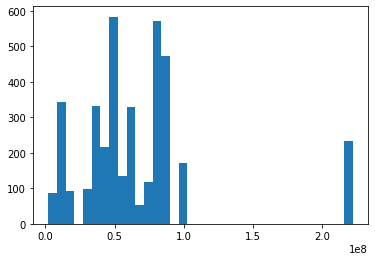

In [123]:
plt.hist(df.units, bins=35);

In [144]:
X = df.drop(columns=['company_name_x',	'device',	'units',	'channel_name'])
y_ = df['units'].sort_values()

In [145]:
y = y_.copy()

In [146]:
y[y_<0.25e8], y[(y_>=0.25e8)&(y_<=0.75e8)], y[(y_>0.75e8)&(y_<=1e8)], y[y_>1e8] = 'A','B','C', 'D'

In [147]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2)

### LogisticRegression()

In [148]:
log_reg_model = LogisticRegression(max_iter=X.shape[0]).fit(X_train_val,y_train_val)
log_r2 = log_reg_model.score(X_test,y_test)
y_pred = log_reg_model.predict(X_test)
log_adj_r2 = 1 - (1-log_reg_model.score(X_train_val, y_train_val))*(len(y_train_val)-1)/(len(y_train_val)-X_train_val.shape[1]-1)
log_reg_scores = {'adj r2': log_adj_r2, 
                  'accuracy_score': accuracy_score(y_test, y_pred)}
print(log_reg_scores)

{'adj r2': 0.4465508651706691, 'accuracy_score': 0.48239895697522817}


### SVM

In [151]:
clf = svm.SVC()
clf.fit(X_train_val, y_train_val)
y_pred = clf.predict(X_test)

svm_r2 = clf.score(X_test,y_test)
svm_adj_r2 = 1 - (1-clf.score(X_train_val, y_train_val))*(len(y_train_val)-1)/(len(y_train_val)-X_train_val.shape[1]-1)

svm_scores = {'adj r2': svm_adj_r2, 
              'accuracy_score': accuracy_score(y_test, y_pred)}
print(svm_scores)

{'adj r2': 0.49133676680777394, 'accuracy_score': 0.516297262059974}


### RandomForestRegressor()

In [156]:
X = df_.drop(columns=['units'])
y = df_['units'].sort_values()
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2)

In [162]:
regr = RandomForestRegressor(max_depth=2)
regr.fit(X_train_val, y_train_val)
RandomForestRegressor_scores = {'SCORE': regr.score(X_train_val,y_train_val),
                                'MAE': mean_absolute_error(regr.predict(X_test),y_test),
                                'MSE': mean_squared_error(regr.predict(X_test),y_test)}
print(RandomForestRegressor_scores)

{'SCORE': 0.6179541964497788, 'MAE': 21319539.314396553, 'MSE': 892940764409815.6}


## Final Scores

In [159]:
df_Lin_Mod_Scrs = pd.DataFrame([LR_model_scores,Lasso_model_scores,
                   Ridge_model_scores,
                   ElasticNet_model_scores,
                   LR_model_scores_no_dummies,
                   Lasso_model_scores_no_dummies,
                   Ridge_model_scores_no_dummies,
                   ElasticNet_model_scores_no_dummies,
                   LR_model_scores_polynomial,
                   Lasso_model_scores_polynomial,
                   Ridge_model_scores_polynomial,
                   ElasticNet_model_scores_polynomial,
                   LR_model_scores_GBU,
                   Lasso_model_scores_GBU,
                   Ridge_model_scores_GBU,
                   ElasticNet_model_scores_GBU],
                  index = ['LR_scores','Lasso_scores',
                   'Ridge_scores',
                   'ElasticNet_scores',
                   'LR_scores_no_dummies',
                   'Lasso_scores_no_dummies',
                   'Ridge_scores_no_dummies',
                   'ElasticNet_scores_no_dummies',
                   'LR_scores_polynomial',
                   'Lasso_scores_polynomial',
                   'Ridge_scores_polynomial',
                   'ElasticNet_scores_polynomial',
                   'LR_scores_GBU',
                   'Lasso_scores_GBU',
                   'Ridge_scores_GBU',
                   'ElasticNet_scores_GBU']
)
df_clf_scores = pd.DataFrame([log_reg_scores,svm_scores],index=['log_reg_scores','svm_scores'])


In [160]:
df_Lin_Mod_Scrs 

,Mean Squared Error,Mean Absolute Error,r2,adj r2
LR_scores,1.408567e+12,3.426751e+04,0.999494,0.999343
Lasso_scores,5.176838e+12,9.208493e+04,1.000000,1.000000
Ridge_scores,4.049330e+12,8.591945e+04,1.000000,1.000000
ElasticNet_scores,4.141975e+12,1.484324e+05,0.999982,0.999981
LR_scores_no_dummies,2.496177e+15,3.213008e+07,0.007458,-0.009062
Lasso_scores_no_dummies,2.113519e+15,3.056255e+07,0.011684,0.010068
Ridge_scores_no_dummies,2.113519e+15,3.056255e+07,0.011684,0.010068
ElasticNet_scores_no_dummies,2.113520e+15,3.056257e+07,0.011684,0.010068
LR_scores_polynomial,3.471290e+15,3.488909e+07,-0.415715,-0.439277
Lasso_scores_polynomial,2.088664e+15,3.107696e+07,0.041594,0.040027


In [161]:
df_clf_scores

,adj r2,accuracy_score
log_reg_scores,0.446551,0.482399
svm_scores,0.491337,0.516297


In [163]:
RandomForestRegressor_scores

{'MAE': 21319539.314396553,
 'MSE': 892940764409815.6,
 'SCORE': 0.6179541964497788}